# JWST light curve from rateint.fits file


## Dataset Description
### The following datset are from jwst NIRSEPC BOTS data 

#### Dataset available at https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html

In [1]:
from astropy.io import fits
import numpy as np

##### Countrate products are produced by applying the ramp_fitting step to the integrations within an exposure, in order to compute count rates from the original accumulating signal ramps. For exposures that contain multiple integrations (NINTS > 1) this is done in two ways, which results in two separate products. First, countrates are computed for each integration within the exposure, the results of which are stored in a rateints product. These products contain 3-D data arrays, where each plane of the data cube contains the countrate image for a given integration

##### for more information visit the site https://jwst-pipeline.readthedocs.io/en/stable/jwst/data_products/science_products.html

##### Rateint int comes from stage 1 processing of uncall data. These data come from single exposures and are usually contained within a single FITS file. However, when the raw data volume for an individual exposure is large enough, like for time-series observations, the uncalibrated data can be broken into multiple segments less than 2GB each, so as to keep total file sizes to a reasonable level. Such broken-up exposures usually include "segNNN" in the file names, where NNN is 1-indexed and always includes any leading zeros https://jwst-docs.stsci.edu/accessing-jwst-data/jwst-science-data-overview

In [2]:
#since jwst ligth curve are segmeneted
Required_files = [
    "jw01366003001_04101_00001-seg001_nrs2_rateints.fits",
    "jw01366003001_04101_00001-seg002_nrs2_rateints.fits",
    "jw01366003001_04101_00001-seg003_nrs2_rateints.fits",
    
]

##### Data Description
##### SCI: 3-D data array containing the pixel values, in units of DN/s. The first two dimensions are equal to the size of the detector readout, with the data from multiple integrations stored along the 3rd axis.

##### ERR: 3-D data array containing uncertainty estimates on a per-integration basis. These values are based on the combined VAR_POISSON and VAR_RNOISE data (see below), given as standard deviation.

##### DQ: 3-D data array containing DQ flags. Each plane of the cube corresponds to a given integration.

##### INT_TIMES: A table of beginning, middle, and end time stamps for each integration in the exposure.

##### VAR_POISSON: 3-D data array containing the per-integration variance estimates for each pixel, based on Poisson noise only.

##### VAR_RNOISE: 3-D data array containing the per-integration variance estimates for each pixel, based on read noise only.

##### ADSF: The data model meta data.

In [3]:
#check data 
file_to_check = Required_files[2]
hdul = fits.open(file_to_check)
hdul.info()

Filename: jw01366003001_04101_00001-seg003_nrs2_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     249   ()      
  1  SCI           1 ImageHDU        63   (2048, 32, 155)   float32   
  2  ERR           1 ImageHDU        11   (2048, 32, 155)   float32   
  3  DQ            1 ImageHDU        12   (2048, 32, 155)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   155R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 32, 155)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 32, 155)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [8279B]   


In [4]:
file_to_check = Required_files[1]
hdul = fits.open(file_to_check)
hdul_dict = dict(hdul[0].header)
hdul_dict

{'SIMPLE': True,
 'BITPIX': 8,
 'NAXIS': 0,
 'EXTEND': True,
 'DATE': '2023-11-10T17:45:04.472',
 'ORIGIN': 'STSCI',
 'TIMESYS': 'UTC',
 'TIMEUNIT': 's',
 'FILENAME': 'jw01366003001_04101_00001-seg002_nrs2_rateints.fits',
 'SDP_VER': '2023_2a',
 'PRD_VER': 'PRDOPSSOC-062',
 'OSS_VER': '008.004.011.000',
 'GSC_VER': 'GSC2431',
 'CAL_VER': '1.12.0',
 'CAL_VCS': 'RELEASE',
 'DATAMODL': 'CubeModel',
 'TELESCOP': 'JWST',
 'HGA_MOVE': False,
 'PWFSEET': 59790.60304303241,
 'NWFSEST': 59792.63712440972,
 'COMPRESS': False,
 '': 
 Program information
 
 
 Observation identifiers
 
 
 Visit information
 
 
 Target information
 
 
 Instrument configuration information
 
 
 Exposure parameters
 
 
 Subarray parameters
 
 
 Dither information
 
 
 Aperture information
 
 
 Velocity aberration correction information
 
 
 Time information
 
 
 Guide star information
 
 
 Reference file information
 
 
 CRDS parameters
 
 
 Gain reference file information
 
 
 IPC reference file information
 
 
 Line

In [6]:
num_integration , x_dim , y_dim = hdul["SCI"].data.shape
print(f"y dim =  {y_dim}")
print(f"x dim = {x_dim}")
print(f"num_integration = {num_integration}")



y dim =  2048
x dim = 32
num_integration = 155


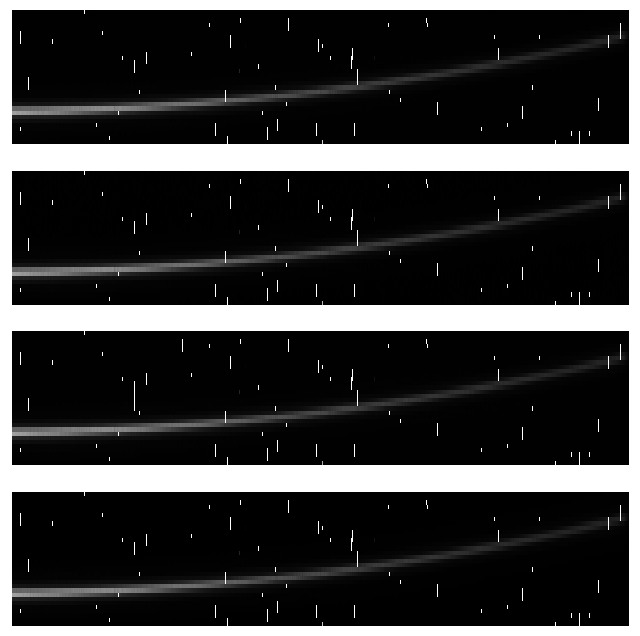

In [7]:
# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sl_fig, axs = plt.subplots(ncols=1, nrows=4, figsize=[8, 8])

for i, ax in enumerate(axs.flat):
    im = ax.imshow(hdul["SCI"].data[i, :, :], 
                   origin='lower', 
                   aspect='auto', 
                   interpolation='none',
                   cmap='grey')
    ax.axis("off")  

In [8]:
#concatenating all the data into a singal array
all_flux = []


# Loop through all segments
for file_name in Required_files:
    with fits.open(file_name) as hdul:
        ini_array = hdul["SCI"].data 
        data = np.where(np.isnan(ini_array), np.ma.array(ini_array, 
                   mask=np.isnan(ini_array)).mean(axis=0), ini_array)
        flux = np.nansum(data, axis=(1, 2)) 

        all_flux.extend(flux)

all_flux = np.array(all_flux)
all_flux.shape


(465,)

In [9]:
#Time
time_check = fits.open(file_to_check)
time_arr = time_check["INT_TIMES"].data
print(time_arr[0][1:])
print(time_arr.shape) 

# Its is an 1d array with [num int,times (as listed below)]
# MJD-BEG
# MJD-AVG
# MJD-END
# TDB-BEG
# TDB-MID
# TDB-END

(59791.03434152641, 59791.03470703642, 59791.035072546445, 59791.03505320115, 59791.03541867594, 59791.03578415075)
(155,)


In [10]:
all_time = []
for file_name in Required_files:
    with fits.open(file_name) as hdul_time:
        time_lc = hdul_time["INT_TIMES"].data
        for i in range(time_lc.shape[0]):
            all_time.append(time_lc[i][1:][0])

all_time = np.array(all_time)


In [11]:
#verification since shape for time and flux should be same 
print(all_time.shape)
print(all_flux.shape)

(465,)
(465,)


In [12]:
from stingray import Lightcurve

lc = Lightcurve(all_time,all_flux)

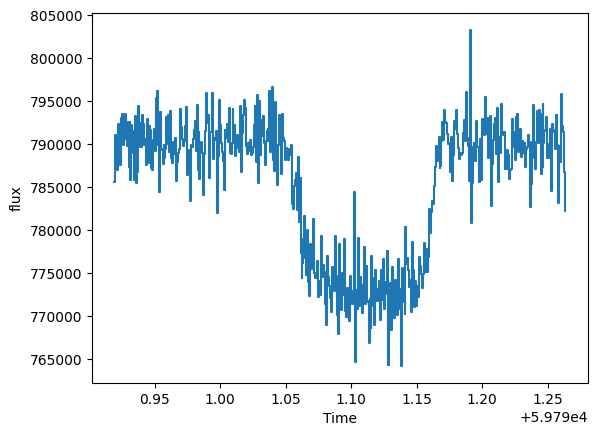

In [13]:
lc.plot(labels = ['Time','flux'])
plt.show()

### Lets use poisson regression to find the genral trend and smoothen it 


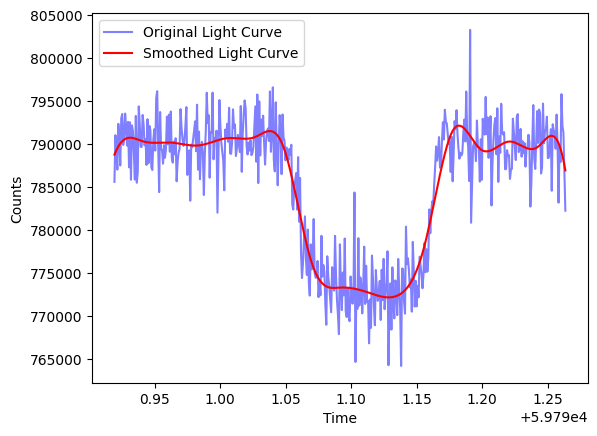

In [14]:
from Poissonregressor import smoothend_light_curve
lc_to_smothen = lc 
smoothed_lc = smoothend_light_curve(lc_to_smothen ,n_knots=17)
plt.plot(lc.time, lc.counts, label="Original Light Curve", color="blue",alpha=0.5)

# Plot smoothed light curve
plt.plot(smoothed_lc.time, smoothed_lc.counts, label="Smoothed Light Curve", color="red")


# Formatting the plot
plt.xlabel("Time")
plt.ylabel("Counts")
plt.legend()
plt.show()

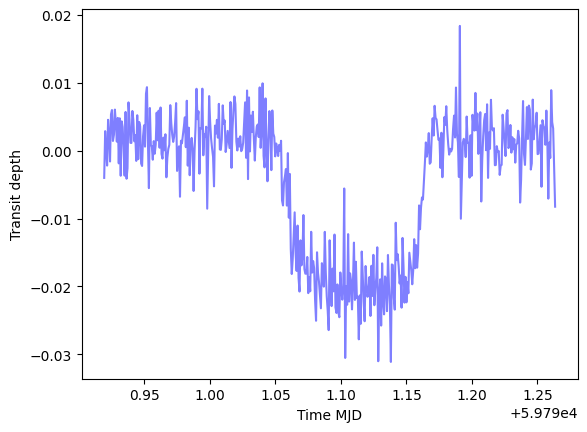

In [21]:
#reformed light curve 
new_units = ((lc.counts-np.median(lc.counts))/np.median(lc.counts))
plt.plot(lc.time, new_units, label="Original Light Curve", color="blue",alpha=0.5)
plt.ylabel(r"Transit depth")
plt.xlabel("Time MJD")
plt.show()

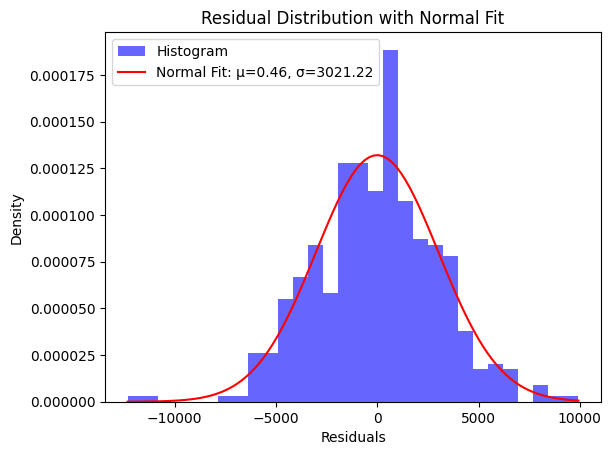

In [22]:

import matplotlib.pyplot as plt
from scipy.stats import norm

residuals = smoothed_lc.counts - lc.counts

mu, sigma = norm.fit(residuals)

plt.hist(residuals, bins=30, density=True, alpha=0.6, color='b', label="Histogram")

x = np.linspace(min(residuals), max(residuals), 100)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r-', label=f'Normal Fit: μ={mu:.2f}, σ={sigma:.2f}')

plt.xlabel("Residuals")
plt.ylabel("Density")
plt.title("Residual Distribution with Normal Fit")
plt.legend()
plt.show()


## Now for spectroscopy i will use jwst pipeline

In [16]:
# from pipeline import process_spec2
# process_spec2(Required_files)
print("Extraction complete!!!")

Extraction complete!!!


## Now we use x1d int.fits file we will use that for our spectroscopic analysis that we got from the pipeline


In [23]:
extracted_files = [
    "JWST/jw01366003001_04101_00001-seg001_nrs2_x1dints.fits",
    "JWST/jw01366003001_04101_00001-seg002_nrs2_x1dints.fits",
    "JWST/jw01366003001_04101_00001-seg003_nrs2_x1dints.fits",
    
]

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def extract_and_plot(files):
    plt.figure(figsize=(10, 5))

    for file in files:
        with fits.open(file) as temp:
                num_integration = temp[0].header["INTEND"] - temp[0].header["INTSTART"] + 1
                wavlen = temp[2].data["WAVELENGTH"]
                summed_flux = np.zeros_like(temp[2].data["FLUX"])
                summed_error = np.zeros_like(temp[2].data["FLUX_ERROR"])
                
                flux = temp[2].data["FLUX"]  # Assuming index 2 corresponds to INTSTART
                data = np.where(np.isnan(flux), np.ma.array(flux, 
                   mask=np.isnan(flux)).mean(axis=0), flux)
                
                flux_corr = np.nansum(data, axis=0)
                
                error = temp[2].data["FLUX_ERROR"]
                data_error = np.where(np.isnan(error), np.ma.array(error, 
                   mask=np.isnan(error)).mean(axis=0), error)
                flux_error = np.nansum(data_error, axis=0)
                
                for j in range(num_integration):
                    flux = temp[j + 2].data["FLUX"]
                    error = temp[j + 2].data["FLUX_ERROR"]
                    error = (error/flux_error)**2
                    summed_flux = np.nansum([summed_flux, flux], axis=0)
                    summed_error = np.nansum([summed_error, error], axis=0)
                summed_flux = (1-np.sqrt(np.abs(summed_flux-flux_corr)/flux_corr))**2
                summed_error = (1-np.sqrt(np.abs(summed_error-flux_error)/flux_error))**2
                
                return wavlen, summed_flux,summed_error

# Lets see light curve of a specific wavelength

In [26]:
def extract_wavlength_based_flux(files):
    all_wavlen = None
    all_fluxes = []
    total_integrations = 0
    
    for file in files:
        with fits.open(file) as temp:
            num_integration = temp[0].header["INTEND"] - temp[0].header["INTSTART"] + 1
            
            wavlen = temp[2].data["WAVELENGTH"]
            wavlen = np.asarray(wavlen).reshape(-1)  
            
            if all_wavlen is None:
                all_wavlen = wavlen
            else:
                if not np.array_equal(all_wavlen, wavlen):
                    print(f"Warning: Wavelengths differ in {file}. Using first file's wavelengths.")
            
            for j in range(num_integration):
                flux = temp[j + 2].data["FLUX"]
                flux = np.where(np.isnan(flux), np.ma.array(flux, 
                   mask=np.isnan(flux)).mean(axis=0), flux)
                flux = np.asarray(flux).reshape(-1) 
                all_fluxes.append(flux)
                total_integrations += 1
    
    all_fluxes = np.array(all_fluxes)  
    
    output_matrix = np.zeros((len(all_wavlen), 1 + total_integrations))
    output_matrix[:, 0] = all_wavlen  
    output_matrix[:, 1:] = all_fluxes.T 
    
    print(f"Output matrix shape: {output_matrix.shape}")
    
    return output_matrix

Output matrix shape: (2048, 466)


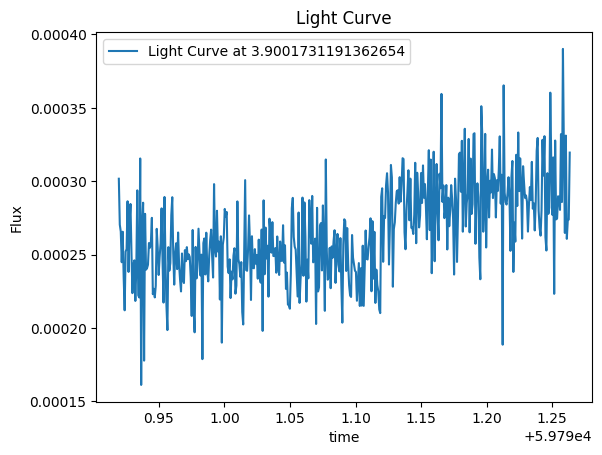

In [30]:
matrix = extract_wavlength_based_flux(extracted_files)
import matplotlib.pyplot as plt
row_idx = 120
plt.plot(all_time,matrix[row_idx, 1:], label=f'Light Curve at {matrix[row_idx, 0]}')

plt.xlabel('time')
plt.ylabel('Flux')
plt.title('Light Curve')
plt.legend()
plt.show()

# Lets see planet's transit spectrum

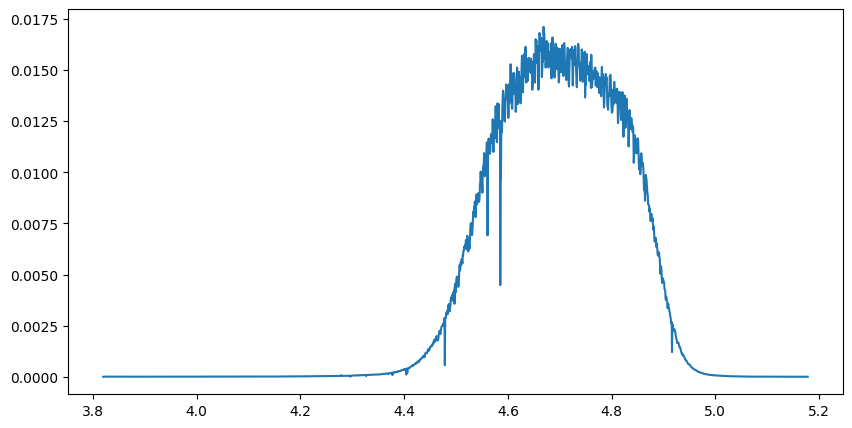

In [ ]:
wavlen,flux,error= extract_and_plot(extracted_files)
data_array = np.column_stack((wavlen, flux, error))
plt.errorbar(wavlen,flux,yerr =error)
